# Imports

In [ ]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPool2D,
    SpatialDropout2D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

2025-02-17 20:27:00.826664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 20:27:00.959264: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 20:27:01.036308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739824021.157376 1647672 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739824021.187177 1647672 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 20:27:01.388480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Setting Directory for Storing Data

* Directory structure where all the datasets and compiled models will be stored
* They will be stored in the directory called `data`
* Compiled models will be stored in `data/models`

In [ ]:
BASE_DATA_DIR = "data"
DATASETS: dict[str, str] = {
    "mnist": os.path.join(BASE_DATA_DIR, "mnist"),
    "emnist": os.path.join(BASE_DATA_DIR, "emnist"),
    "handwritten_digits": os.path.join(BASE_DATA_DIR, "handwritten-digits-not-mnist"),
    "usps": os.path.join(BASE_DATA_DIR, "usps"),
    "models": os.path.join(BASE_DATA_DIR, "models"),
}

for directory in DATASETS.values():
    os.makedirs(directory, exist_ok=True)

# Helper Functions to Analyse Data

* Prints the number of samples for each dataset

In [8]:
def print_dataset_summary(dataset_name: str, count: int) -> None:
    print(f"{dataset_name:<30} : {count:>8,d} samples")

* Takes labels and a dataset name as input
* It calculates and prints the distribution of classes within the provided labels
* Specifically, it counts the occurrences of each unique label (representing different classes/digits) and then prints these counts along with the dataset name and the total number of samples
* This is useful for understanding the balance or imbalance of classes in a dataset

In [9]:
def print_class_distribution(labels, dataset_name) -> None:
    """Print distribution of classes in a dataset"""
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{dataset_name} class distribution:")
    for digit, count in zip(unique, counts):
        print(f"Digit {digit}: {count} samples")
    print(f"Total samples: {len(labels)}")

* Displays the total number of samples

In [10]:
def print_total_samples(labels, dataset_name) -> None:
    """Print only total samples in a dataset"""
    print(f"{dataset_name}: {len(labels)} samples")

* Displays the number 3
* This is useful to visualise each dataset such that they can be normalised

In [ ]:
def show_digit_3(images, labels, dataset_name: str) -> None:
    """Display first occurrence of digit 3 in dataset"""
    idx = np.where(labels == 3)[0][0]
    plt.figure(figsize=(3, 3))
    plt.imshow(images[idx].reshape(28, 28), cmap="gray")
    plt.title(f"Digit 3 from {dataset_name}")
    plt.axis("off")
    plt.show()

# Loading Data

## Loading MNIST Dataset

* Built into Keres

In [ ]:
def load_mnist_data():
    (x_train, labels_train), (x_test, labels_test) = mnist.load_data()

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    show_digit_3(x_train, labels_train, "MNIST")

    return x_train, labels_train, x_test, labels_test

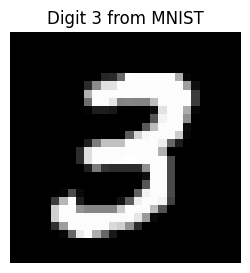

In [13]:
x_train_mnist, labels_train_mnist, x_test, labels_test = load_mnist_data()
x_train_mnist = x_train_mnist.reshape(-1, 28, 28, 1)
y_train_mnist = tf.keras.utils.to_categorical(labels_train_mnist, 10)

In [14]:
print_dataset_summary("MNIST Train", len(labels_train_mnist))
print_dataset_summary("MNIST Test", len(labels_test))

MNIST Train                    :   60,000 samples
MNIST Test                     :   10,000 samples


## Loading Handwritten Digits Dataset (not in MNIST)

* Loading dataset from directory
* This dataset has transparent background with black foreground making it inconsistent from the other datasets so it is processed

In [ ]:
def load_handwritten_digits():
    images = []
    labels = []
    dataset_path: str = os.path.join(DATASETS["handwritten_digits"], "dataset")

    for label in range(10):
        folder_path = os.path.join(dataset_path, str(label), str(label))
        if not os.path.exists(folder_path):
            print(f"Warning: Missing directory for label {label} - {folder_path}")
            continue

        file_count = len(
            [name for name in os.listdir(folder_path) if name.endswith(".png")]
        )
        print(f"Processing {file_count} samples for digit {label}")

        for filename in os.listdir(folder_path):
            if filename.endswith(".png"):
                img_path = os.path.join(folder_path, filename)
                try:
                    with Image.open(img_path).convert("RGBA") as rgba_img:
                        bg = Image.new("RGBA", rgba_img.size, (255, 255, 255, 255))
                        bg.paste(rgba_img, (0, 0), rgba_img)
                        img = bg.convert("L")

                    img = img.resize((28, 28))

                    img_array = np.array(img).astype("float32") / 255.0
                    # invert so digits are white on black
                    img_array = 1.0 - img_array
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
                    continue

    images = np.array(images)
    labels = np.array(labels)

    show_digit_3(images, labels, "Handwritten (not MNIST)")

    return images, labels

Processing 10773 samples for digit 0
Processing 10773 samples for digit 1
Processing 10773 samples for digit 2
Processing 10773 samples for digit 3
Processing 10773 samples for digit 4
Processing 10773 samples for digit 5
Processing 10773 samples for digit 6
Processing 10773 samples for digit 7
Processing 10773 samples for digit 8
Processing 10773 samples for digit 9


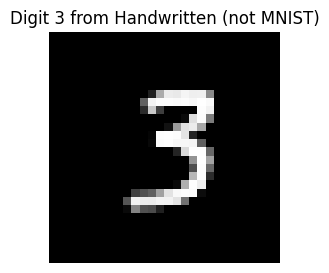

In [16]:
handwritten_images, handwritten_labels = load_handwritten_digits()
handwritten_images = handwritten_images.reshape(-1, 28, 28, 1)
handwritten_labels_cat = tf.keras.utils.to_categorical(handwritten_labels, 10)

In [17]:
print_dataset_summary("Handwritten Digits (not MNIST)", len(handwritten_labels))

Handwritten Digits (not MNIST) :  107,730 samples


## Loading EMNIST Dataset

* Loading from directory

In [ ]:
def load_emnist_data():
    train_file = os.path.join(DATASETS["emnist"], "emnist-digits-train.csv")

    try:
        if not os.path.exists(train_file):
            print(f"Error: EMNIST data file not found at {train_file}")
            print("\nAvailable files in EMNIST directory:")
            for file in os.listdir(DATASETS["emnist"]):
                print(f"- {file}")
            raise FileNotFoundError(f"EMNIST data file not found at {train_file}")

        print(f"Loading EMNIST data from: {train_file}")

        import pandas as pd

        data = pd.read_csv(train_file)

        if data.empty:
            raise ValueError("Loaded CSV file is empty")

        labels = data.iloc[:, 0].values
        pixels = data.iloc[:, 1:].values

        images = pixels.reshape(-1, 28, 28)
        images = images.transpose(0, 2, 1)
        images = np.flip(images, axis=1)

        images = images.astype("float32") / 255.0

        show_digit_3(images, labels, "EMNIST")

        return images, labels

    except Exception as e:
        print(f"Error loading EMNIST data: {str(e)}")
        return None, None


Loading EMNIST data from: data/emnist/emnist-digits-train.csv


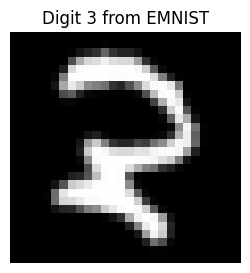

In [19]:
emnist_images, emnist_labels = load_emnist_data()
emnist_images = emnist_images.reshape(-1, 28, 28, 1)
emnist_labels_cat = tf.keras.utils.to_categorical(emnist_labels, 10)

In [20]:
print_dataset_summary("EMNIST", len(emnist_labels))

EMNIST                         :  239,999 samples


## Loading USPS Dataset

In [ ]:
def load_usps_data():
    import h5py

    usps_path: str = os.path.join(DATASETS["usps"], "usps.h5")

    if not os.path.exists(usps_path):
        raise FileNotFoundError(f"USPS dataset file not found at {usps_path}")

    with h5py.File(usps_path, "r") as hf:
        train = hf.get("train")
        X_train = train.get("data")[:]
        y_train = train.get("target")[:]

    print("Resizing USPS images from 16x16 to 28x28...")
    resized_images = []
    for img in X_train:
        img = img.reshape(16, 16)
        img_resized = resize(img, (28, 28), anti_aliasing=True)
        resized_images.append(img_resized)

    images = np.array(resized_images)
    images = images.astype("float32")
    if images.max() > 1.0:
        images /= 255.0

    show_digit_3(images, y_train, "USPS")

    return images, y_train

Resizing USPS images from 16x16 to 28x28...


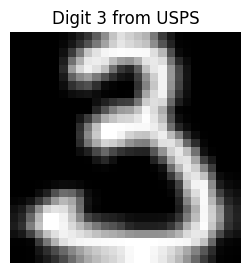

In [22]:
usps_images, usps_labels = load_usps_data()
usps_images = usps_images.reshape(-1, 28, 28, 1)
usps_labels_cat = tf.keras.utils.to_categorical(usps_labels, 10)

In [23]:
print_dataset_summary("USPS", len(usps_labels))

USPS                           :    7,291 samples


# Combining Datasets

In [ ]:
x_train_combined = np.concatenate(
    [x_train_mnist, handwritten_images, emnist_images, usps_images]
)
y_train_combined = np.concatenate(
    [y_train_mnist, handwritten_labels_cat, emnist_labels_cat, usps_labels_cat]
)

In [ ]:
x_train_combined, y_train_combined = shuffle(
    x_train_combined, y_train_combined, random_state=42
)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_combined, y_train_combined, test_size=0.1, random_state=42
)

In [27]:
print(f"\nTotal combined samples: {len(x_train_combined)}")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print_dataset_summary("Total Combined", len(x_train_combined))


Total combined samples: 415020
Training samples: 373518
Validation samples: 41502
Total Combined                 :  415,020 samples


# Data Augmentation

## Offline Augmentation 

* Define composite transform pipeline with varying probabilities
* Combine transforms into one Compose:
  - 100% chance (p=1.0) for ElasticTransform
  - 20% chance (p=0.2) for GaussNoise
  - 15% chance (p=0.15) for small 4x4 dropout
  - 10% chance (p=0.1) for brightness/contrast
  - 5% chance (p=0.05) to invert image

In [ ]:
augmentation_transform = A.Compose(
    [
        # Geometric Transforms
        A.ElasticTransform(alpha=50, sigma=5, p=1.0),
        # Noise/Pixel-Level Transforms
        A.GaussNoise(var_limit=(10, 20), p=0.2),
        A.CoarseDropout(max_holes=1, max_height=4, max_width=4, fill_value=0.0, p=0.15),
        # Color/Intensity Transforms
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.1),
        A.InvertImg(p=0.05),
    ]
)

/tmp/ipykernel_1623730/2113161089.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 20), p=0.2),
/tmp/ipykernel_1623730/2113161089.py:7: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


### Augmentation Processing

In [29]:
augmented_images = []
augmented_labels = []

for i in range(len(x_train)):
    # Prepare image for augmentation
    image_0_1 = x_train[i, :, :, 0]
    image_255 = (image_0_1 * 255).astype(np.uint8)

    # Apply augmentation pipeline
    augmented = augmentation_transform(image=image_255)
    aug_img_255 = augmented["image"]

    # Post-process augmented image
    aug_img_01 = aug_img_255.astype(np.float32) / 255.0
    aug_img_01 = np.expand_dims(aug_img_01, axis=-1)

    augmented_images.append(aug_img_01)
    augmented_labels.append(y_train[i])

### Combining Datasets

* Combine augmented dataset with original dataset

In [30]:
# Convert lists to numpy arrays
augmented_images = np.array(augmented_images, dtype=np.float32)
augmented_labels = np.array(augmented_labels)

In [31]:
# Combine original and augmented datasets
original_size = len(x_train)
x_train = np.concatenate([x_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_labels], axis=0)

In [32]:
print(f"Original training size: {original_size} | After augmentation: {len(x_train)}")

Original training size: 373518 | After augmentation: 747036


## Real-time Augmentation

In [ ]:
# Keras ImageDataGenerator for on-the-fly augmentation
datagen = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1
)
datagen.fit(x_train)

steps_per_epoch = len(x_train) // 256

In [ ]:
print("\nAfter augmentation (per epoch):")
print(f"Training samples (now doubled): {len(x_train)}")
print(f"Augmented samples per epoch: {steps_per_epoch * 256}")


After augmentation (per epoch):
Training samples (now doubled): 747036
Augmented samples per epoch: 747008


# Model Optimisation

## Gradient Clipping

* Setting `clipnorm=1.0` to effectively "snip" gradients whose norm > 1.0

In [ ]:
clipped_adam = tf.keras.optimizers.Adam(
    learning_rate=1e-3,  # default LR
    clipnorm=1.0,
)

2025-02-16 13:59:20.394800: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Model

## Convolutional Neural Network (CNN)

* 2 convolutional blocks with increasing filters (32 → 64)
* Regularization techniques:
* BatchNormalization after each conv layer
* SpatialDropout2D (20%) after each conv block
* L2 regularization in dense layer
* Dropout (50%) before final classification
* Final 10-way softmax for classification (likely MNIST digits)

In [ ]:
model = Sequential(
    [
        # --- Block 1 ---
        Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        SpatialDropout2D(0.2),
        # --- Block 2 (Modified: 96 filters) ---
        Conv2D(96, (3, 3), activation="relu"),
        BatchNormalization(),
        Conv2D(96, (3, 3), activation="relu"),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        SpatialDropout2D(0.2),
        # --- Block 3 ---
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        MaxPool2D((2, 2)),
        SpatialDropout2D(0.2),
        # --- Dense layers (Modified: 1050 units) ---
        Flatten(),
        Dense(1050, activation="relu", kernel_regularizer="l2"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation="softmax"),
    ]
)

/home/maruf/.cache/pypoetry/virtualenvs/pattern-recognition-neural-network-coursew-8OHAYx0u-py3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-17 20:27:14.333186: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 12, 12, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 96)     │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 4, 4, 96)       │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 2, 2, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1050)           │       538,650 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 934,064 (3.56 MB)

 Trainable params: 930,940 (3.55 MB)

 Non-trainable params: 3,124 (12.20 KB)

## Model Compilation

* Configures the training process for the neural network with three key components:

* Optimizer:
  * Uses a custom clipped_adam optimizer
  * Likely an Adam optimizer with gradient clipping to prevent exploding gradients
  * Gradient clipping helps stabilize training

* Loss Function:
  * Categorical_crossentropy: Standard loss function for multi-class classification
  * Appropriate for the 10-class MNIST digit classification task
  * Expects one-hot encoded labels

* Metrics:
  * Tracks accuracy during training and validation
  * Will show percentage of correctly classified images
  * This compilation step must be done before training the model 

* It defines how the model will:
  * Update weights (optimizer)
  * Calculate errors (loss)
  * Measure performance (metrics)

In [ ]:
model.compile(
    optimizer=clipped_adam,  # using the clipped optimizer
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Keras Callbacks Configuration

1. Early Stopping
   * Prevents overfitting by stopping training when validation loss stops improving
   * Waits 5 epochs (patience=5) before stopping
   * Restores the best weights found during training
2. Model Checkpoint
   * Saves the model when validation accuracy improves
   * Only keeps the best performing model
   * Saves to 'best_model.h5' in the models directory
3. Learning Rate Reduction
   * Reduces learning rate when validation loss plateaus
   * Reduces by 20% (factor=0.2) after 3 epochs without improvement
   * Won't reduce below 1e-6

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(
        os.path.join(DATASETS["models"], "best_model.h5"),
        save_best_only=True,
        monitor="val_accuracy",
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6),
]

## Training

* Trains the model using augmented data via datagen.flow
* Uses batch size of 256 images
* Validates on non-augmented validation set
* Runs for 5 epochs
* Uses the callbacks for early stopping, checkpointing, and LR reduction
* Stores training history in history variable

In [ ]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=256),
    validation_data=(x_val, y_val),
    epochs=150,
    callbacks=callbacks,
)

/home/maruf/.cache/pypoetry/virtualenvs/pattern-recognition-neural-network-coursew-8OHAYx0u-py3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 83/422 ━━━━━━━━━━━━━━━━━━━━ 3:24 602ms/step - accuracy: 0.5108 - loss: 5.4161

KeyboardInterrupt: 

## Saving Model

* Saves the final model state after training
* Stores it as 'final_model.h5' in the models directory
* Different from the checkpoint callback which saves the best model during training
* Includes model architecture, weights, and training configuration

In [ ]:
model.save(os.path.join(DATASETS["models"], "final_model.h5"))